#### basics

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [442]:
df = pd.read_csv('bank-full.csv',sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [444]:
feat = list(['age','job','marital','education','balance','housing','contact','day',
             'month','duration','campaign','pdays','previous','poutcome','y'])

In [445]:
print(len(df.columns))
for col in df.columns:
    if str(col) not in feat:
        df = df.drop(col,axis=1)

print(len(df.columns))        

15
15


In [228]:
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [446]:
df.y = (df.y == 'yes').astype(int)
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,0


#### Question 1

In [447]:
#split dataset
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

y_train_full = df_train_full.y.values

y_train = df_train.y.values
y_val = df_val.y.values

del df_train['y']
del df_val['y']


In [7]:
from sklearn.metrics import roc_auc_score

In [448]:
numerical = [col for col in df_train.columns if df[col].dtype != 'object']
categorical = [col for col in df_train.columns if col not in numerical]
display(numerical)
display(categorical)

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [232]:
scores = []
for feature in numerical:
   
   score = roc_auc_score(y_train, df_train[feature])
   scores.append((feature, score))
   
df_scores = pd.DataFrame(data=scores)
df_scores.columns = ['Feature','Score']
df_scores.sort_values(by='Score', ascending=False)

,Feature,Score
3,duration,0.814700
6,previous,0.598565
5,pdays,0.590128
1,balance,0.588831
0,age,0.487814
2,day,0.474042
4,campaign,0.428546


#### Question 2

In [38]:
from sklearn.metrics import auc

In [342]:
# one-hot encoding
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

In [343]:
# training
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [344]:
#predictions
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
model.fit(X_val, y_val)
y_pred = model.predict_proba(X_val)[:, 1]

In [358]:

def tpr_fpr_dataframe(y_val, y_pred,thresholds):
    scores = []

    # thresholds = np.arange(0, 1, 0.01)

    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()

        scores.append((t, tp, fp, fn, tn))

    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [351]:
df_scores = tpr_fpr_dataframe(y_val,y_pred,np.arange(0, 1, 0.01))


In [352]:
df_scores

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,1098,7944,0,0,1.000000,1.000000
1,0.01,1096,7056,2,888,0.998179,0.888218
2,0.02,1091,5894,7,2050,0.993625,0.741944
3,0.03,1087,4946,11,2998,0.989982,0.622608
4,0.04,1068,4145,30,3799,0.972678,0.521777
...,...,...,...,...,...,...,...
95,0.95,34,16,1064,7928,0.030965,0.002014
96,0.96,29,14,1069,7930,0.026412,0.001762
97,0.97,23,10,1075,7934,0.020947,0.001259
98,0.98,16,5,1082,7939,0.014572,0.000629


In [353]:
round(auc(df_scores.fpr, df_scores.tpr),10)

0.8999084782

#### Question 3

In [400]:
df_scores = tpr_fpr_dataframe(y_val,y_pred,np.arange(0, 1, 0.01))

In [401]:
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [402]:
for idx, data in df_scores.iterrows():
    if data.recall <= data.precision: 
        print(data.threshold)
        break

0.28


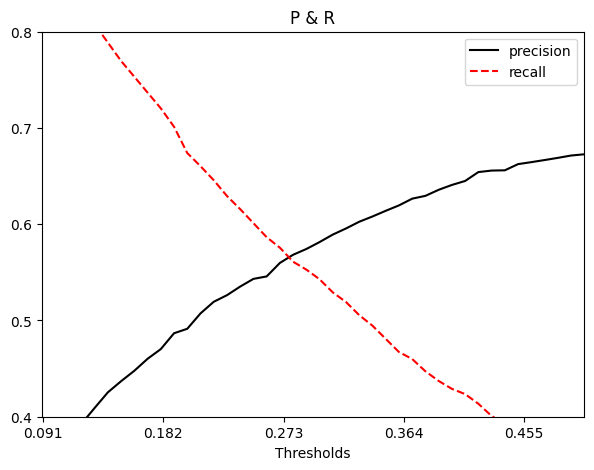

In [409]:
plt.figure(figsize=(7, 5))

plt.plot(df_scores.threshold, df_scores.precision, color='black', linestyle='solid', label='precision')
plt.plot(df_scores.threshold, df_scores.recall, color='red', linestyle='dashed', label='recall')
plt.legend()

plt.xticks(np.linspace(0, 1, 12))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('P & R')

plt.xlim((0.09, 0.5))
plt.ylim((0.4, 0.8))
plt.show()

#### Question 4

In [396]:
# F1 scores
df_scores['f1'] = (2*df_scores.precision * df_scores.recall)/(df_scores.precision + df_scores.recall)
df_scores.sort_values(by='f1', ascending=False).head(1)

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall,f1
22,0.22,709,656,389,7288,0.645719,0.082578,0.519414,0.645719,0.575721


#### Question 5

In [459]:
from sklearn.model_selection import KFold

In [449]:
def train(df, y):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X, y)

    return dv, model

In [450]:
def predict(df, dv, model):
    categories = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(categories)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [451]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [452]:
aucs = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.y.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.y.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [458]:
print(f'AUC = {np.mean(aucs):.3f} +/- {np.std(aucs):.4f}')

AUC = 0.906 +/- 0.0053


#### Question 6

In [461]:
C_list = [0.000001, 0.001, 1]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)


In [489]:
def train_c(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)

    return dv, model

In [498]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in C_list:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train_c(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print(f'C={C}, AUC = {np.mean(aucs):.3f} +/- {np.std(aucs):.3f}')

C=1e-06, AUC = 0.701 +/- 0.009
C=0.001, AUC = 0.861 +/- 0.007
C=1, AUC = 0.906 +/- 0.005
